In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Change working directory to be current folder
import os
os.chdir('/content/drive/MyDrive/MyColab/ISSMPM')
!ls

Mounted at /content/drive
 dataset
 DelawarePainDatabase_StimulusCharacterization_forOSF.xlsx
 FaceDetection_CNN_classification.ipynb
 FaceDetection_CNN_Regression_2022_04_01_06_24_08.ipynb
 FaceDetection_CNN_Regression_2022_04_01_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_04_16_23_41.ipynb
 FaceDetection_CNN_Regression_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_04_09.ipynb
 FaceDetection_CNN_Regression_TransferLearning_2022_05_12.ipynb
 FaceDetection_CNN_Regression_TransferLearning.ipynb
 FaceDetection_CNN_Regression_TransferLearning_withVideoDataframe.ipynb
 FaceDetection_haar.ipynb
 FaceDetection.ipynb
 faceexp-comparison-data-test-public.csv
 PainRecognition_CNN_Regression.ipynb
 PainRecognition_TransferLearning.ipynb
 training
'Video Processing2.ipynb'
'Video Processing.ipynb'


In [ ]:
#installation of mediapipe library
!pip install mediapipe

     |████████████████████████████████| 32.8 MB 1.4 MB/s 


In [ ]:
#import require library
import cv2
import os
import numpy as np
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Activation
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras import optimizers,regularizers
import sklearn
from sklearn.model_selection import train_test_split
import datetime as dt

import tensorflow as tf
from google.colab.patches import cv2_imshow
import mediapipe as mp
import imutils
from collections import deque
import pickle


print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.8.0
numpy:       1.21.6
matplotlib:  3.2.2
sklearn:     1.0.2


In [ ]:
#Define the ResNet50 Transfer Learning model which has been built on PainRecognition_TransferLearning.ipynb
optmz = SGD(lr=1e-4, momentum=0.9, decay=1e-4/20)
base = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
modelname   = 'PainRecognition'
folderpath      = '/content/drive/MyDrive/MyColab/ISSMPM/training/'
filepath        = f'{folderpath}{modelname}_transferlearning_withVideoDataframe_Final.hdf5'

def createModel():
  h = base.output

  x1 = Flatten(name="flatten_class")(h)
  x1 = Dense(16, activation="relu",name='dense16_class')(x1)
  x1 = Dropout(0.25)(x1)
  output1 = Dense(2, activation="softmax",name='class')(x1)

  x2 = Conv2D(4096,(2,2),padding='same',name='reg1_conv2d')(h)
  x2 = Activation('relu')(x2)
  x2 = AveragePooling2D(pool_size=(3, 3))(x2)
  x2 = Dropout(0.25)(x2)

  x2 = Flatten(name="flatten_reg")(x2)
  x2 = Dense(128,activation='relu',name='dense128_reg')(x2)
  x2 = Dropout(0.5)(x2)
  x2 = Dense(16,activation='relu',name='dense16_reg')(x2)
  x2 = Dropout(0.25)(x2)
  output2 = Dense(1,activation='linear',name='reg')(x2)
 
  model = Model(inputs=base.input, outputs=[output1,output2])
  for layer in base.layers:
    if layer.name not in ['conv5_block3_3_conv','conv5_block3_3_bn']:
      layer.trainable = False
  model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optmz, metrics=['accuracy','MeanSquaredError'])
  return model

modelGo     = createModel()

#load the weight trained in PainRecognition_TransferLearning.ipynb
modelGo.load_weights(filepath)
print("Model weights loaded from:", filepath)

modelGo.compile(loss=['categorical_crossentropy', 'mse'],
                   optimizer=optmz,
                  metrics=['accuracy','MeanSquaredError'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


94781440/94765736 [==============================] - 0s 0us/step
Model weights loaded from: /content/drive/MyDrive/MyColab/ISSMPM/training/PainRecognition_transferlearning_withVideoDataframe_Final.hdf5


In [ ]:
#make prediction on the self recorded video withSpec_nopain_correctpose
filename = 'withSpec_nopain_correctpose'
cap = cv2.VideoCapture(f'dataset/Video/{filename}.mp4')

#The optimized frame number for running the double-ended queue
optimizedLengthOfFrames = 10
queueForClass = deque(maxlen=optimizedLengthOfFrames)
queueForReg = deque(maxlen=optimizedLengthOfFrames)
optimizedClassList = []

#Define MediaPipe face detection pretrained model
mp_face_detection = mp.solutions.face_detection

withSpec_nopain_correctpose_outcome = []
FrameNumber = 0

#Define the pain expression threshold for the model. Greater than threshold will be considered as pain face.
PainExpressionThreshold = 2.8
while True:

  #read the video frame
  ret, frame = cap.read()
  singleFramePrediction ={}

  #if the video frame is detected, proceed to detect the bounding box of the face, else release the video frame
  if ret:
    if FrameNumber%100==0:
      print(f'Starting to process frame {FrameNumber}...')

    #rotate the frame as it is not in the correct position
    img = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    singleFramePrediction['FrameNumber'] = FrameNumber
    singleFramePrediction['BoundingBox'] = None
    singleFramePrediction['ColorCode'] = None
    singleFramePrediction['PainExpression'] = None

    singleFramePrediction['PainRecognition'] = None
    singleFramePrediction['ActualClass'] = None
    singleFramePrediction['ActualReg'] = None

    #increase the number for next frame
    FrameNumber += 1

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        #skip the frame if there is no face detection
        if not results.detections:
          withSpec_nopain_correctpose_outcome.append(singleFramePrediction)
          continue
        #skip the frame if there is more than one bounding box of the face
        if len(results.detections)>1:
          withSpec_nopain_correctpose_outcome.append(singleFramePrediction)
          continue
        
        #Calculate the bounding box of the box from the result of Medipipe face detection
        row, column,channel = img.shape
        y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
        h = int(results.detections[0].location_data.relative_bounding_box.height*row)
        x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
        w = int(results.detections[0].location_data.relative_bounding_box.width*column)
        face = img[y:y + h, x:x + w]

        #Resize all the images to 100x100 first amd expand to 224x224.
        #This is because the face detected on the self recorded video has an average size of 100x100 but the input size of the transfer learning model is 224x224
        resized = cv2.resize(face, (100, 100))
        resized = cv2.resize(resized, (224, 224))

        #All te image are converted into grayscale as the pain expression should be color invariant. Stack as three channel to fit the transfer learning model
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        resized = np.dstack((resized,resized,resized))

        #Image data is required to be normalized to fit the transfer learning model. Feed into the trained model to make prediction on the face
        preprocessed = preprocess_input(resized)
        preprocessed = np.array([preprocessed]).reshape(-1,224,224,3)
        currentframe_predict_class,currentframe_predict_reg    = modelGo.predict(preprocessed)

        queueForClass.append(currentframe_predict_class[0])
        queueForReg.append(currentframe_predict_reg[0][0])

        predictoutClass = np.array(queueForClass).mean(axis=0) if len(queueForClass)==optimizedLengthOfFrames else currentframe_predict_class[0]
        predictoutReg = np.array(queueForReg).mean(axis=0) if len(queueForReg)==optimizedLengthOfFrames else currentframe_predict_reg[0][0]

        singleFramePrediction['BoundingBox'] = (x,y,w,h)
        singleFramePrediction['ColorCode'] = (0,0,255) if predictoutReg>PainExpressionThreshold else (0,255,0)
        singleFramePrediction['PainExpression'] = predictoutReg

        singleFramePrediction['PainRecognition'] = predictoutClass
        singleFramePrediction['ActualClass'] = currentframe_predict_class[0]
        singleFramePrediction['ActualReg'] = currentframe_predict_reg[0][0]

        withSpec_nopain_correctpose_outcome.append(singleFramePrediction)
  else:
    cap.release()
    break

Starting to process frame 0...
Starting to process frame 100...
Starting to process frame 200...
Starting to process frame 300...
Starting to process frame 400...
Starting to process frame 500...
Starting to process frame 600...
Starting to process frame 700...
Starting to process frame 800...
Starting to process frame 900...
Starting to process frame 1000...
Starting to process frame 1100...
Starting to process frame 1200...


Video Pain Recognition Actual Accuracy: 0.1270358306188925

Video Pain Optimized Recognition Accuracy: 0.1270358306188925

Video Pain Expression Optimized Mean: 2.5524020195007324

Video Pain Expression Actual Mean: 2.552170515060425

Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : 0.09364820846905537

Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : 0.12866449511400652



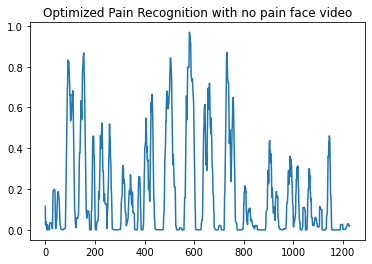

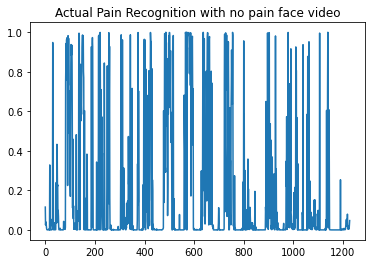

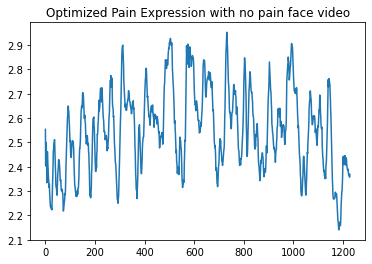

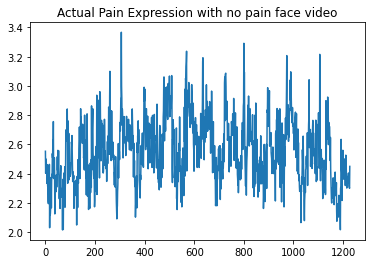

In [ ]:
optimizedClassList = [ dictData.get('PainRecognition')[1] for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')]
actualClassList = [ dictData.get('ActualClass')[1] for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')]

optimizedRegList = [ dictData.get('PainExpression') for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')]
actualRegList = [ dictData.get('ActualReg') for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')]

OptimizedPainRecognised = sum([ dictData.get('PainRecognition')[1]> dictData.get('PainRecognition')[0] for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')])
ActualPainRecognised = sum([ dictData.get('ActualClass')[1]> dictData.get('ActualClass')[0] for dictData in withSpec_nopain_correctpose_outcome if dictData.get('BoundingBox')])
print(f'Video Pain Recognition Actual Accuracy: {(OptimizedPainRecognised/len(actualClassList))}\n')
print(f'Video Pain Optimized Recognition Accuracy: {(OptimizedPainRecognised/len(optimizedClassList))}\n')

OptimizedPainExpression = np.mean(optimizedRegList)
ActualPainExpression = np.mean(actualRegList)
OptimizedPainBeyondThreshold = sum([regvalue>2.8 for regvalue in optimizedRegList])
ActualPainBeyondThreshold = sum([regvalue>2.8 for regvalue in actualRegList])

print(f'Video Pain Expression Optimized Mean: {OptimizedPainExpression}\n')
print(f'Video Pain Expression Actual Mean: {ActualPainExpression}\n')
print(f'Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : {OptimizedPainBeyondThreshold/len(optimizedRegList)}\n')
print(f'Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : {ActualPainBeyondThreshold/len(actualRegList)}\n')

plt.figure()
plt.plot(optimizedClassList, label="class_nopain_optimized")
plt.title('Optimized Pain Recognition with no pain face video',fontsize=12)

plt.figure()
plt.plot(actualClassList, label="class_nopain_actual")
plt.title('Actual Pain Recognition with no pain face video',fontsize=12)

plt.figure()
plt.plot(optimizedRegList, label="reg_nopain_optimized")
plt.title('Optimized Pain Expression with no pain face video',fontsize=12)

plt.figure()
plt.plot(actualRegList, label="reg_nopain_optimized")
plt.title('Actual Pain Expression with no pain face video',fontsize=12)
ax = plt.gca()

exportPredictions = []
for dictData in withSpec_nopain_correctpose_outcome:
  singleFramePrediction = {}
  singleFramePrediction['FrameNumber'] = dictData['FrameNumber']
  singleFramePrediction['BoundingBox'] = dictData['BoundingBox']
  singleFramePrediction['ColorCode'] = dictData['ColorCode']
  singleFramePrediction['PainExpression'] = dictData['PainExpression']
  singleFramePrediction['PainScore'] = OptimizedPainExpression/5
  exportPredictions.append(singleFramePrediction)

with open(f'/content/drive/MyDrive/MyColab/ISSMPM/training/withSpec_nopain_correctpose_outcome.pkl','wb') as f:
  pickle.dump(exportPredictions,f)


In [ ]:
#make prediction on the self recorded video withSpec_nopain_correctpose
filename = 'withSpec_pain_incorrectpose'
cap = cv2.VideoCapture(f'dataset/Video/{filename}.mp4')

#The optimized frame number for running the double-ended queue
optimizedLengthOfFrames = 10
queueForClass = deque(maxlen=optimizedLengthOfFrames)
queueForReg = deque(maxlen=optimizedLengthOfFrames)
optimizedClassList = []

#Define MediaPipe face detection pretrained model
mp_face_detection = mp.solutions.face_detection

withSpec_pain_incorrectpose_outcome = []
FrameNumber = 0

#Define the pain expression threshold for the model. Greater than threshold will be considered as pain face.
PainExpressionThreshold = 2.8
while True:

  #read the video frame
  ret, frame = cap.read()
  singleFramePrediction ={}

  #if the video frame is detected, proceed to detect the bounding box of the face, else release the video frame
  if ret:
    if FrameNumber%100==0:
      print(f'Starting to process frame {FrameNumber}...')

    #rotate the frame as it is not in the correct position
    img = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)
    singleFramePrediction['FrameNumber'] = FrameNumber
    singleFramePrediction['BoundingBox'] = None
    singleFramePrediction['ColorCode'] = None
    singleFramePrediction['PainExpression'] = None

    singleFramePrediction['PainRecognition'] = None
    singleFramePrediction['ActualClass'] = None
    singleFramePrediction['ActualReg'] = None

    #increase the number for next frame
    FrameNumber += 1

    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
        # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        #skip the frame if there is no face detection
        if not results.detections:
          withSpec_pain_incorrectpose_outcome.append(singleFramePrediction)
          continue
        #skip the frame if there is more than one bounding box of the face
        if len(results.detections)>1:
          withSpec_pain_incorrectpose_outcome.append(singleFramePrediction)
          continue
        
        #Calculate the bounding box of the box from the result of Medipipe face detection
        row, column,channel = img.shape
        y = int(results.detections[0].location_data.relative_bounding_box.ymin*row)
        h = int(results.detections[0].location_data.relative_bounding_box.height*row)
        x = int(results.detections[0].location_data.relative_bounding_box.xmin*column)
        w = int(results.detections[0].location_data.relative_bounding_box.width*column)
        face = img[y:y + h, x:x + w]

        #Resize all the images to 100x100 first amd expand to 224x224.
        #This is because the face detected on the self recorded video has an average size of 100x100 but the input size of the transfer learning model is 224x224
        resized = cv2.resize(face, (100, 100))
        resized = cv2.resize(resized, (224, 224))

        #All te image are converted into grayscale as the pain expression should be color invariant. Stack as three channel to fit the transfer learning model
        resized = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        resized = np.dstack((resized,resized,resized))

        #Image data is required to be normalized to fit the transfer learning model. Feed into the trained model to make prediction on the face
        preprocessed = preprocess_input(resized)
        preprocessed = np.array([preprocessed]).reshape(-1,224,224,3)
        currentframe_predict_class,currentframe_predict_reg    = modelGo.predict(preprocessed)

        queueForClass.append(currentframe_predict_class[0])
        queueForReg.append(currentframe_predict_reg[0][0])

        predictoutClass = np.array(queueForClass).mean(axis=0) if len(queueForClass)==optimizedLengthOfFrames else currentframe_predict_class[0]
        predictoutReg = np.array(queueForReg).mean(axis=0) if len(queueForReg)==optimizedLengthOfFrames else currentframe_predict_reg[0][0]

        singleFramePrediction['BoundingBox'] = (x,y,w,h)
        singleFramePrediction['ColorCode'] = (0,0,255) if predictoutReg>PainExpressionThreshold else (0,255,0)
        singleFramePrediction['PainExpression'] = predictoutReg

        singleFramePrediction['PainRecognition'] = predictoutClass
        singleFramePrediction['ActualClass'] = currentframe_predict_class[0]
        singleFramePrediction['ActualReg'] = currentframe_predict_reg[0][0]

        withSpec_pain_incorrectpose_outcome.append(singleFramePrediction)
  else:
    cap.release()
    break

Starting to process frame 0...
Starting to process frame 100...
Starting to process frame 200...
Starting to process frame 300...
Starting to process frame 400...
Starting to process frame 500...
Starting to process frame 600...
Starting to process frame 700...
Starting to process frame 800...
Starting to process frame 900...
Starting to process frame 1000...
Starting to process frame 1100...
Starting to process frame 1200...
Starting to process frame 1300...
Starting to process frame 1400...


Video Pain Recognition Actual Accuracy: 0.9685534591194969

Video Pain Optimized Recognition Accuracy: 0.9685534591194969

Video Pain Expression Optimized Mean: 3.292424201965332

Video Pain Expression Actual Mean: 3.295808792114258

Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : 0.9741439552760307

Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : 0.9622641509433962



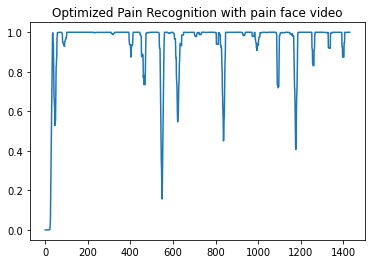

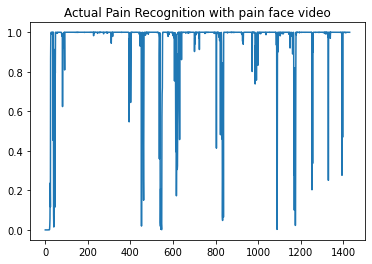

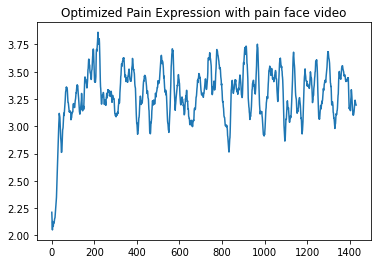

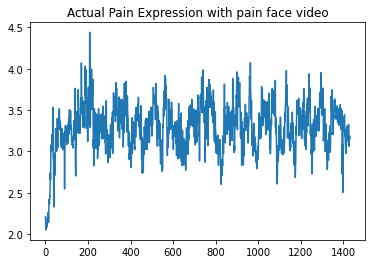

In [ ]:
optimizedClassList = [ dictData.get('PainRecognition')[1] for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')]
actualClassList = [ dictData.get('ActualClass')[1] for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')]

optimizedRegList = [ dictData.get('PainExpression') for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')]
actualRegList = [ dictData.get('ActualReg') for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')]

OptimizedPainRecognised = sum([ dictData.get('PainRecognition')[1]> dictData.get('PainRecognition')[0] for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')])
ActualPainRecognised = sum([ dictData.get('ActualClass')[1]> dictData.get('ActualClass')[0] for dictData in withSpec_pain_incorrectpose_outcome if dictData.get('BoundingBox')])
print(f'Video Pain Recognition Actual Accuracy: {(OptimizedPainRecognised/len(actualClassList))}\n')
print(f'Video Pain Optimized Recognition Accuracy: {(OptimizedPainRecognised/len(optimizedClassList))}\n')

OptimizedPainExpression = np.mean(optimizedRegList)
ActualPainExpression = np.mean(actualRegList)
OptimizedPainBeyondThreshold = sum([regvalue>2.8 for regvalue in optimizedRegList])
ActualPainBeyondThreshold = sum([regvalue>2.8 for regvalue in actualRegList])

print(f'Video Pain Expression Optimized Mean: {OptimizedPainExpression}\n')
print(f'Video Pain Expression Actual Mean: {ActualPainExpression}\n')
print(f'Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : {OptimizedPainBeyondThreshold/len(optimizedRegList)}\n')
print(f'Video Pain Frame Detected on pain percentage based on Optimized Pain Expression : {ActualPainBeyondThreshold/len(actualRegList)}\n')

plt.figure()
plt.plot(optimizedClassList, label="class_nopain_optimized")
plt.title('Optimized Pain Recognition with pain face video',fontsize=12)

plt.figure()
plt.plot(actualClassList, label="class_nopain_actual")
plt.title('Actual Pain Recognition with pain face video',fontsize=12)

plt.figure()
plt.plot(optimizedRegList, label="reg_nopain_optimized")
plt.title('Optimized Pain Expression with pain face video',fontsize=12)

plt.figure()
plt.plot(actualRegList, label="reg_nopain_optimized")
plt.title('Actual Pain Expression with pain face video',fontsize=12)
ax = plt.gca()

exportPredictions = []
for dictData in withSpec_pain_incorrectpose_outcome:
  singleFramePrediction = {}
  singleFramePrediction['FrameNumber'] = dictData['FrameNumber']
  singleFramePrediction['BoundingBox'] = dictData['BoundingBox']
  singleFramePrediction['ColorCode'] = dictData['ColorCode']
  singleFramePrediction['PainExpression'] = dictData['PainExpression']
  singleFramePrediction['PainScore'] = OptimizedPainExpression/5
  exportPredictions.append(singleFramePrediction)

with open(f'/content/drive/MyDrive/MyColab/ISSMPM/training/withSpec_pain_incorrectpose_outcome.pkl','wb') as f:
  pickle.dump(exportPredictions,f)


In [ ]:
exportPredictions

[{'BoundingBox': (472, 427, 122, 122),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 0,
  'PainExpression': 2.2108245,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (481, 429, 125, 124),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 1,
  'PainExpression': 2.149354,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (473, 427, 121, 121),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 2,
  'PainExpression': 2.0585835,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (472, 427, 120, 120),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 3,
  'PainExpression': 2.049263,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (471, 427, 121, 121),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 4,
  'PainExpression': 2.1259444,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (471, 427, 121, 121),
  'ColorCode': (0, 255, 0),
  'FrameNumber': 5,
  'PainExpression': 2.1075912,
  'PainScore': 0.6584848403930664},
 {'BoundingBox': (472, 426, 121, 121),
  'ColorCode': (0, 255, 0),
  'FrameNum